In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math

In [46]:
gases = ["CH4", "N2", "CO2"]

In [47]:
#df_dict = {"N2" : pd.read_csv("N2_HKUST-1.csv", comment='#'), "CH4" : pd.read_csv("CH4_HKUST-1.csv", comment='#')}
df_dict = dict(zip(gases, [pd.read_csv(gas+"_HKUST-1.csv", comment='#') for gas in gases]))

In [48]:
df_dict["N2"]["p(bar)"] = df_dict["N2"]["p(MPa)"] * 10

In [49]:
"""
unit conversion
cm3/g --> mmol/g

* L/1000cm3 * mol/22.4L * 1000mmol/mol
"""

'\nunit conversion\ncm3/g --> mmol/g\n\n* L/1000cm3 * mol/22.4L * 1000mmol/mol\n'

In [50]:
df_dict["CH4"]["N(mmol/g)"] = df_dict["CH4"]["cm3/g"] / 22.4

In [51]:
isotherm_dict = {}
for gas in gases:
    isotherm_dict[gas] = iast.ModelIsotherm(df_dict[gas], loading_key="N(mmol/g)", pressure_key="p(bar)", model="Langmuir")

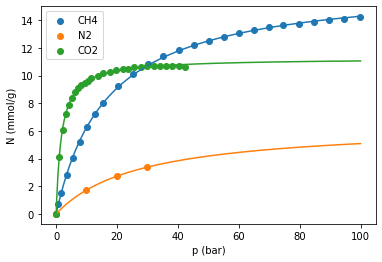

In [52]:
plt.figure()

p_range = np.linspace(0, 100, 500)

for gas in gases:
    plt.scatter(df_dict[gas]["p(bar)"], df_dict[gas]["N(mmol/g)"], marker='o', label=gas)
    plt.plot(p_range, isotherm_dict[gas].loading(p_range))
    
#plt.xlim(0, 5)
plt.xlabel("p (bar)")
plt.ylabel("N (mmol/g)")
plt.legend()

In [53]:
total_p = 1.0 # bar
mol_fxns = np.array([0.91, 0.04, 0.05])

q = iast.iast(total_p * mol_fxns, [isotherm_dict[gas] for gas in gases])

In [54]:
q

array([0.84426335, 0.00826858, 0.29314356])

In [55]:
x_ch4 = np.linspace(0, 1)
m_ads = np.zeros(len(x_ch4))
mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009}

In [56]:
for i in range(len(x_ch4)):
    if x_ch4[i] == 0:
        m_ads[i] = isotherm_dict["N2"].loading(total_p) * mol_wts["N2"] / 1000
        continue
    if x_ch4[i] == 1:
        m_ads[i] = isotherm_dict["CH4"].loading(total_p) * mol_wts["CH4"] / 1000
        continue
        
    mol_fxns = np.array([1 - x_ch4[i], x_ch4[i]])
    q = iast.iast(total_p * mol_fxns, [isotherm_dict[gas] for gas in gases])
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    m_ads[i] = np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

Example use:

              IAST([0.5,0.5], [xe_isotherm, kr_isotherm], verboseflag=true)


Exception: Length of partial pressures != length of array of isotherms...

In [57]:
def adsorbed_mass(mol_fxns):
    q = iast.iast(mol_fxns, [isotherm_dict[gas] for gas in gases], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

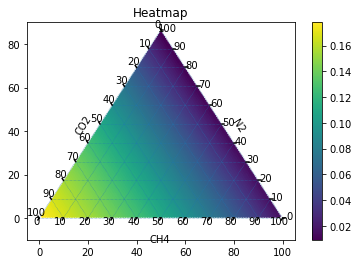

In [69]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

In [62]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

0.016280561364774043

In [66]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

0.007746271186277206

In [61]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

0.17913560157425154

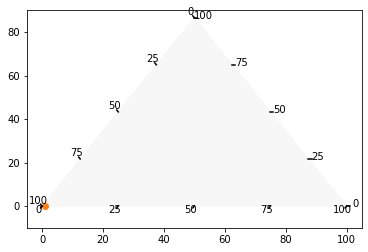

In [64]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")